In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
#from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, precision_recall_fscore_support,f1_score

from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
#from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle
import time
from sklearn.linear_model import LogisticRegression


## Εισαγωγή δεδομένων από αρχεία .dat

In [3]:
res = []
for i in "abcdefghi":
    data = np.genfromtxt("./testdata/xa{}.dat".format(i),
                     skip_header=0,
                     skip_footer=0,
                     names=None,
                     dtype=None,
                     delimiter=' ',
                     encoding="utf8")
    res += list(data)

## Δημιουργία dataset

In [4]:
y=[]
x=[]
for i in range(len(res)):
    y.append(res[i][-1])
    x.append(list(res[i])[:-1])
shape = np.shape(x)
print(shape[0])
print(shape[1])

846
18


## Περιγραφή των δεδομένων

### Παρουσίαση Dataset
Το dataset αποτελείται από πληροφορίες σχετικά με την μορφή διάφορων οχημάτων:
  
  |Χαρακτηριστικό          |Περιγραφή                                                  |
  |------------------------|-----------------------------------------------------------|
  |COMPACTNESS             | (average perim)**2/area                                   |
  |CIRCULARITY             | (average radius)**2/area                                  |
  |DISTANCE CIRCULARITY    | area/(av.distance from border)**2                         |
  |RADIUS RATIO            | (max.rad-min.rad)/av.radius                               |
  |PR.AXIS ASPECT RATIO    | (minor axis)/(major axis)                                 |
  |MAX.LENGTH ASPECT RATIO | (length perp. max length)/(max length)                    |
  |SCATTER RATIO           |  (inertia about minor axis)/(inertia about major axis)    | 
  
  και αποσκοπεί στην ταξινόμησή τους με βάση αποκλειστικά αυτά τα εξωτερικά χαρακτηριστικά.

### Μετατροπές PLaintext
Το dataset μας περιέχει μόνο ακέραιους αριθμούς για την περιγραφή των χαρακτηριστικών, επομένως δεν χρειάζεται να γίνει κάποια επεξεργασία. Η μόνη μετατροπή που χρειάζεται να γίνει στο plaintext είναι η μετατροπή του σε unicode-8 για να είναι δυνατή η ανάγνωση του.

### Πλήθος χαρακτηριστικών και δειγμάτων 
Έχουμε 18 χαρακτηριστικά και 846 δείγματα.

### Ύπαρξη επικεφαλίδων
Ενώ στη περιγραφή του dataset στην ιστοσελίδα του UCI υπάρχουν οι επικεφαλίδες των χαρακτηριστικών, στα αρχεία του dataset που εισάγουμε στο notebook δεν υπάρχουν ούτε επικεφαλίδες ούτε αρίθμηση γραμμών.

### Κλάσεις
Οι κλάσεις του dataset είναι 4: 'opel','saab', 'bus', 'van' και βρίσκονται στην τελευταία στήλη του dataset.
 
### Έλεγχος για απουσιάζουσες τιμές



In [5]:
for i in range(len(x)):
    if(len(x[i]) != 18):
        print("index {} has a problem :(".format(i))

Όπως παρατηρούμε δεν υπάρχουν απουσιάζουσες τιμές. Αυτό είναι λογικό αφού, συμφώνα με την περιγραφή του dataset, οι παράμετροι προέκυψαν από φωτογραφίες οχημάτων από συγκεκριμένη γωνία λήψης.

### Έλεγχος για ισορροπημένο ή όχι dataset.

{'bus': 218, 'opel': 212, 'saab': 217, 'van': 199}


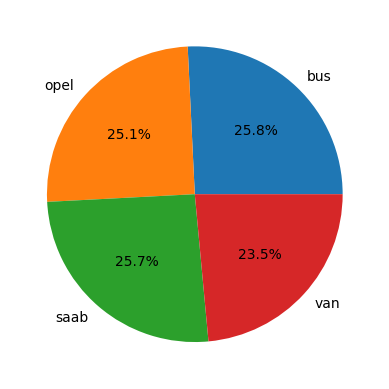

In [6]:
classes=np.unique(y)
class_num={}

for c in classes:
    class_num[c]=0

for i in range(len(y)):
    class_num[y[i]]+=1

print(class_num)
plt.pie(list(class_num.values()),labels=list(class_num.keys()),autopct="%1.1f%%")
plt.show()

Όπως παρατηρούμε το dataset είναι ισορροπημένο. 

## Train Test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)


## Dummy Classifier

In [8]:
dc_uniform = DummyClassifier(strategy="uniform")
dc_constant_bus = DummyClassifier(strategy="constant", constant='bus')
dc_constant_saab = DummyClassifier(strategy="constant", constant='saab')
dc_constant_opel = DummyClassifier(strategy="constant", constant='opel')
dc_constant_van = DummyClassifier(strategy="constant", constant='van')
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")

In [9]:
# hold times for train and pred of out of the box
train_time_base = {}
pred_time_base = {}

In [10]:
# dictionary to store all classifier without optimization preds
predictions = {}

# with the fit method we train the classifier with the train set
# with the predict method predictions occur based on the input data

start_time = time.time()
dc_uniform.fit(X_train, y_train)
train_time_base["DC Uniform"] = time.time() - start_time

start_time = time.time()
predictions["DC Uniform"] = dc_uniform.predict(X_test)
pred_time_base["DC Uniform"] = time.time() - start_time

start_time = time.time()
dc_constant_bus.fit(X_train, y_train)
train_time_base["DC Constant bus"] = time.time() - start_time

start_time = time.time()
predictions["DC Constant bus"] = dc_constant_bus.predict(X_test)
pred_time_base["DC Constant bus"] = time.time() - start_time

start_time = time.time()
dc_constant_saab.fit(X_train, y_train)
train_time_base["DC Constant saab"] = time.time() - start_time

start_time = time.time()
predictions["DC Constant saab"] = dc_constant_saab.predict(X_test)
pred_time_base["DC Constant saab"] = time.time() - start_time

start_time = time.time()
dc_constant_opel.fit(X_train, y_train)
train_time_base["DC Constant opel"] = time.time() - start_time

start_time = time.time()
predictions["DC Constant opel"] = dc_constant_opel.predict(X_test)
pred_time_base["DC Constant opel"] = time.time() - start_time

start_time = time.time()
dc_constant_van.fit(X_train, y_train)
train_time_base["DC Constant van"] = time.time() - start_time

start_time = time.time()
predictions["DC Constant van"] = dc_constant_van.predict(X_test)
pred_time_base["DC Constant van"] = time.time() - start_time

start_time = time.time()
dc_most_frequent.fit(X_train, y_train)
train_time_base["DC Most Frequent"] = time.time() - start_time

start_time = time.time()
predictions["DC Most Frequent"] = dc_most_frequent.predict(X_test)
pred_time_base["DC Most Frequent"] = time.time() - start_time

start_time = time.time()
dc_stratified.fit(X_train, y_train)
train_time_base["DC Stratified"] = time.time() - start_time

start_time = time.time()
predictions["DC Stratified"] = dc_stratified.predict(X_test)
pred_time_base["DC Stratified"] = time.time() - start_time

## Gaussian Naive Bayes (GNB)

In [11]:
gnb = GaussianNB()

start_time = time.time()
gnb.fit(X_train, y_train)
train_time_base["GNB"] = time.time() - start_time

start_time = time.time()
predictions["GNB"] = gnb.predict(X_test)
pred_time_base["GNB"] = time.time() - start_time

## K Nearest Neighbours (kNN)

In [12]:
knn = KNeighborsClassifier(n_neighbors=3)

start_time = time.time()
knn.fit(X_train, y_train)
train_time_base["KNN"] = time.time() - start_time

start_time = time.time()
predictions["KNN"] = knn.predict(X_test)
pred_time_base["KNN"] = time.time() - start_time

## Logistic Regression (LR)

In [13]:
logisticRegr = LogisticRegression()

start_time = time.time()
logisticRegr.fit(X_train, y_train)
train_time_base["LR"] = time.time() - start_time

start_time = time.time()
predictions["LR"] = logisticRegr.predict(X_test)
pred_time_base["LR"] = time.time() - start_time

C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Metrics

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

accuracy = {}
f1 = {}

def metrics_info(classifier_name, preds):
  global accuracy, f1 
  accuracy[classifier_name] = accuracy_score(y_test, preds)
  f1[classifier_name] = f1_score(y_test, preds, average = "macro")

# print bar plot function
def bar_plot(classifiers, scores, title):
  plt.figure(figsize = (10,6))
  y_pos = np.arange(len(classifiers))
  plt.bar(y_pos, scores, align='center', alpha = 0.9)
  plt.xticks(y_pos, classifiers, rotation = 45)
  plt.ylabel('Score')
  plt.title(title)
  plt.show()

In [15]:
# Dummy Metrics
metrics_info("DC Uniform", predictions["DC Uniform"])
metrics_info("DC Constant opel", predictions["DC Constant opel"])
metrics_info("DC Constant saab", predictions["DC Constant saab"])
metrics_info("DC Constant bus", predictions["DC Constant bus"])
metrics_info("DC Constant van", predictions["DC Constant van"])
metrics_info("DC Most Frequent", predictions["DC Most Frequent"])
metrics_info("DC Stratified", predictions["DC Stratified"])

In [16]:
# GNB Metrics
metrics_info("GNB", predictions["GNB"])

In [17]:
# KNN
metrics_info("KNN", predictions["KNN"])

In [18]:
# LR
metrics_info("LR", predictions["LR"])

In [19]:
data = []
data.append(list(accuracy.values()))
data.append(list(f1.values()))
pd.DataFrame(data, index = ["Accuracy Score", "F1 Score"], columns = list(accuracy.keys()))


,DC Uniform,DC Constant opel,DC Constant saab,DC Constant bus,DC Constant van,DC Most Frequent,DC Stratified,GNB,KNN,LR
Accuracy Score,0.192913,0.236220,0.287402,0.244094,0.232283,0.244094,0.244094,0.444882,0.661417,0.732283
F1 Score,0.191719,0.095541,0.111621,0.098101,0.094249,0.098101,0.243939,0.409476,0.659615,0.728670


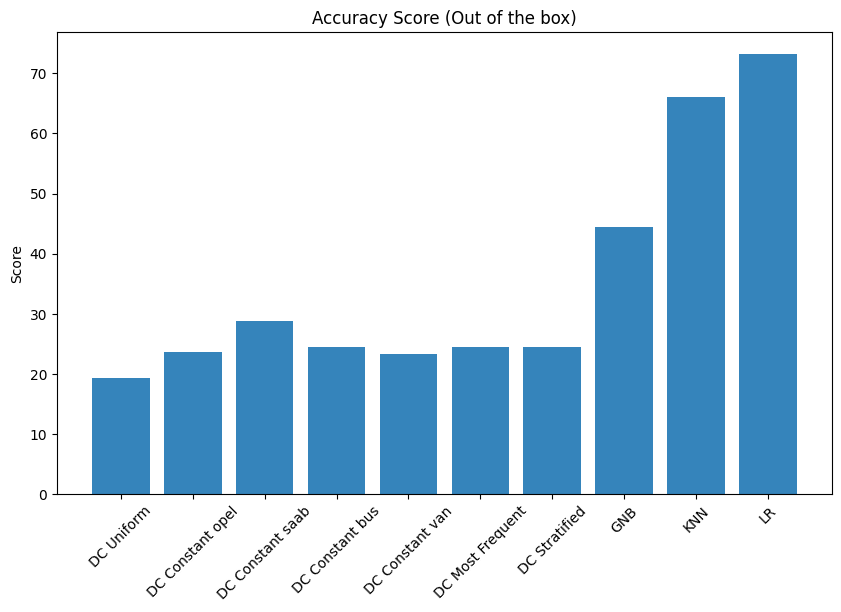

In [20]:
classifier_labels = list(accuracy.keys())
classifier_accuracy = list(accuracy.values())
classifier_f1 = list(f1.values())

bar_plot(classifier_labels, [i*100 for i in classifier_accuracy], "Accuracy Score (Out of the box)")

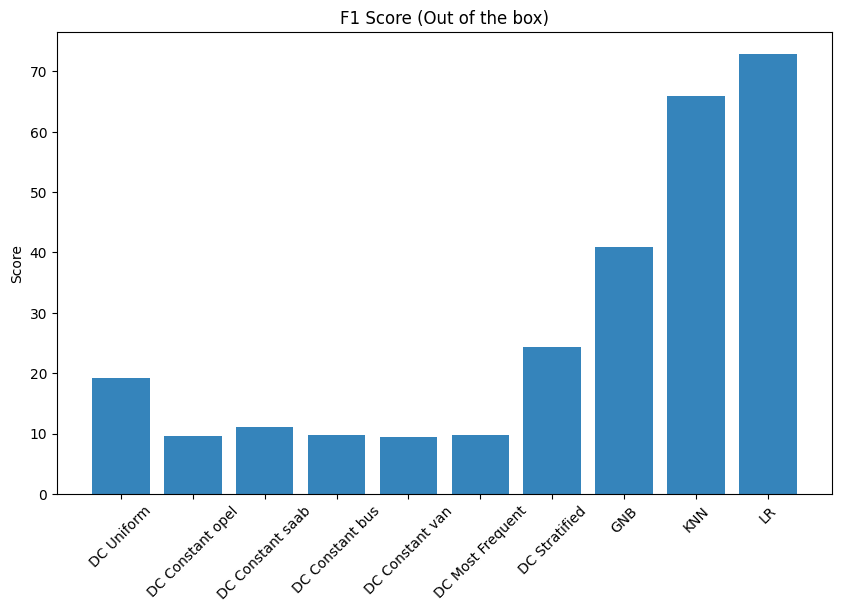

In [21]:
bar_plot(classifier_labels, [i*100 for i in classifier_f1], "F1 Score (Out of the box)")

### Σχολιασμός
Οι μετρικές βγάζουν αρκετά χαμηλές τιμές, όπως είναι αναμενόμενο αφού δεν έχουμε χρησιμοποιήσει καμία μέθοδο βελτιστοποίησης, όυτε καν cross-validation. Ο καλύτερος ταξινομήτης είναι ο Logistic Regression, όπως προκύπτει και από τις δύο μετρικές.

## 10-cross validation


In [22]:
scores_Dummy_acc = cross_val_score(DummyClassifier() , X_train,y_train, cv=10,n_jobs=-1, scoring='accuracy')
scores_Dummy_f1 = cross_val_score(DummyClassifier() , X_train,y_train,cv=10,n_jobs=-1,scoring='f1_macro')

temp = time.time()
scores_knn_acc = cross_val_score(KNeighborsClassifier() , X_train,y_train, cv=10,n_jobs=-1, scoring='accuracy')
times_knn_acc = time.time() - temp
temp = time.time()
scores_knn_f1 = cross_val_score(KNeighborsClassifier() , X_train,y_train,cv=10,n_jobs=-1,scoring='f1_macro')
times_knn_f1 = time.time() - temp

temp = time.time()
scores_GNB_acc = cross_val_score(GaussianNB() , X_train,y_train, cv=10,n_jobs=-1, scoring='accuracy')
times_GNB_acc = time.time() - temp
temp = time.time()
scores_GNB_f1 = cross_val_score(GaussianNB() , X_train,y_train,cv=10,n_jobs=-1,scoring='f1_macro')
times_GNB_f1 = time.time() - temp

temp = time.time()
scores_LR_acc = cross_val_score(LogisticRegression() , X_train,y_train, cv=10,n_jobs=-1, scoring='accuracy')
times_LR_acc = time.time() - temp
temp = time.time()
scores_LR_f1 = cross_val_score(LogisticRegression() , X_train,y_train,cv=10,n_jobs=-1,scoring='f1_macro')
times_LR_f1 = time.time() - temp

scores_acc = []
scores_f1 = []
times_acc = [times_knn_acc,times_GNB_acc,times_LR_acc]
times_f1 = [times_knn_f1,times_GNB_f1,times_LR_f1]
names = ["Dummy","kNN","GNB","LR"]
scores_acc.append(np.mean(scores_Dummy_acc))
scores_f1.append(np.mean(scores_Dummy_f1))
scores_acc.append(np.mean(scores_knn_acc))
scores_f1.append(np.mean(scores_knn_f1 ))
scores_acc.append(np.mean(scores_GNB_acc))
scores_f1.append(np.mean(scores_GNB_f1 ))
scores_acc.append(np.mean(scores_LR_acc))
scores_f1.append(np.mean(scores_LR_f1))

In [23]:
pd.DataFrame([scores_acc,scores_f1],index = ["accuracy","f1"], columns = names)

,Dummy,kNN,GNB,LR
accuracy,0.263559,0.643644,0.457853,0.707797
f1,0.104270,0.635625,0.424270,0.699300


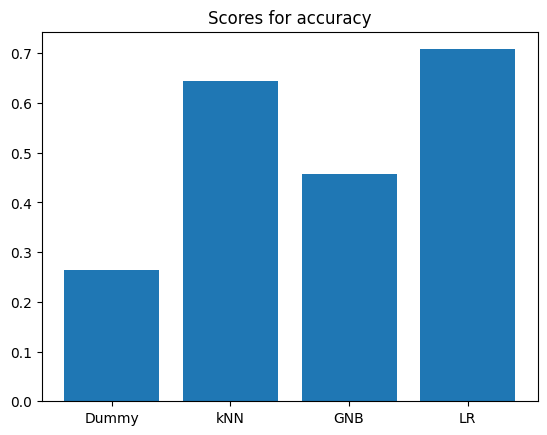

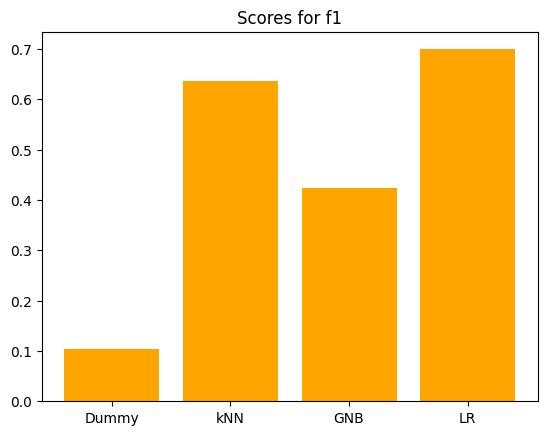

In [24]:
plt.bar(names,scores_acc)
plt.title("Scores for accuracy")
plt.show()
plt.bar(names,scores_f1,color='orange')
plt.title("Scores for f1")
plt.show()

## Data Preprossecing

In [25]:
selector = VarianceThreshold(threshold=0)
train_reduced = selector.fit_transform(X_train)
mask = selector.get_support()
test_reduced = np.array(X_test)[:,mask]

print("Selected futures {} out of {}".format(len(train_reduced[0]),len(X_train[0])))


Selected futures 18 out of 18


In [26]:
def classfication(X_train,y_train,X_test,y_test):
    
    
    dc_uniform = DummyClassifier(strategy="uniform")
    dc_constant_bus = DummyClassifier(strategy="constant", constant='bus')
    dc_constant_saab = DummyClassifier(strategy="constant", constant='saab')
    dc_constant_opel = DummyClassifier(strategy="constant", constant='opel')
    dc_constant_van = DummyClassifier(strategy="constant", constant='van')
    dc_most_frequent = DummyClassifier(strategy="most_frequent")
    dc_stratified = DummyClassifier(strategy="stratified")

    # hold times for train and pred of out of the box
    train_time_base = {}
    pred_time_base = {}
    # dictionary to store all classifier without optimization preds
    predictions = {}

    # with the fit method we train the classifier with the train set
    # with the predict method predictions occur based on the input data

    start_time = time.time()
    dc_uniform.fit(X_train, y_train)
    train_time_base["DC Uniform"] = time.time() - start_time

    start_time = time.time()
    predictions["DC Uniform"] = dc_uniform.predict(X_test)
    pred_time_base["DC Uniform"] = time.time() - start_time

    start_time = time.time()
    dc_constant_bus.fit(X_train, y_train)
    train_time_base["DC Constant bus"] = time.time() - start_time

    start_time = time.time()
    predictions["DC Constant bus"] = dc_constant_bus.predict(X_test)
    pred_time_base["DC Constant bus"] = time.time() - start_time

    start_time = time.time()
    dc_constant_saab.fit(X_train, y_train)
    train_time_base["DC Constant saab"] = time.time() - start_time

    start_time = time.time()
    predictions["DC Constant saab"] = dc_constant_saab.predict(X_test)
    pred_time_base["DC Constant saab"] = time.time() - start_time

    start_time = time.time()
    dc_constant_opel.fit(X_train, y_train)
    train_time_base["DC Constant opel"] = time.time() - start_time

    start_time = time.time()
    predictions["DC Constant opel"] = dc_constant_opel.predict(X_test)
    pred_time_base["DC Constant opel"] = time.time() - start_time

    start_time = time.time()
    dc_constant_van.fit(X_train, y_train)
    train_time_base["DC Constant van"] = time.time() - start_time

    start_time = time.time()
    predictions["DC Constant van"] = dc_constant_van.predict(X_test)
    pred_time_base["DC Constant van"] = time.time() - start_time

    start_time = time.time()
    dc_most_frequent.fit(X_train, y_train)
    train_time_base["DC Most Frequent"] = time.time() - start_time

    start_time = time.time()
    predictions["DC Most Frequent"] = dc_most_frequent.predict(X_test)
    pred_time_base["DC Most Frequent"] = time.time() - start_time

    start_time = time.time()
    dc_stratified.fit(X_train, y_train)
    train_time_base["DC Stratified"] = time.time() - start_time

    start_time = time.time()
    predictions["DC Stratified"] = dc_stratified.predict(X_test)
    pred_time_base["DC Stratified"] = time.time() - start_time


    logisticRegr = LogisticRegression()

    start_time = time.time()
    logisticRegr.fit(X_train, y_train)
    train_time_base["LR"] = time.time() - start_time

    start_time = time.time()
    predictions["LR"] = logisticRegr.predict(X_test)
    pred_time_base["LR"] = time.time() - start_time


    gnb = GaussianNB()
    start_time = time.time()
    gnb.fit(X_train, y_train)
    train_time_base["GNB"] = time.time() - start_time

    start_time = time.time()
    predictions["GNB"] = gnb.predict(X_test)
    pred_time_base["GNB"] = time.time() - start_time

    knn = KNeighborsClassifier(n_neighbors=3)

    start_time = time.time()
    knn.fit(X_train, y_train)
    train_time_base["KNN"] = time.time() - start_time
    
    start_time = time.time()
    predictions["KNN"] = knn.predict(X_test)
    pred_time_base["KNN"] = time.time() - start_time


    metrics_info("DC Uniform", predictions["DC Uniform"])
    metrics_info("DC Constant opel", predictions["DC Constant opel"])
    metrics_info("DC Constant saab", predictions["DC Constant saab"])
    metrics_info("DC Constant bus", predictions["DC Constant bus"])
    metrics_info("DC Constant van", predictions["DC Constant van"])
    metrics_info("DC Most Frequent", predictions["DC Most Frequent"])
    metrics_info("DC Stratified", predictions["DC Stratified"])
    metrics_info("GNB", predictions["GNB"])
    metrics_info("KNN", predictions["KNN"])
    metrics_info("LR", predictions["LR"])
    classifier_labels = list(accuracy.keys())
    classifier_accuracy = list(accuracy.values())
    classifier_f1 = list(f1.values())

        
    data = []
    data.append(list(accuracy.values()))
    data.append(list(f1.values()))

    print(pd.DataFrame(data, index = ["Accuracy Score", "F1 Score"], columns = list(accuracy.keys())))
    
    bar_plot(classifier_labels, [i*100 for i in classifier_accuracy], "Accuracy Score")
    bar_plot(classifier_labels, [i*100 for i in classifier_f1], "F1 Score")
    

                DC Uniform  DC Constant opel  DC Constant saab  \
Accuracy Score    0.244094          0.236220          0.287402   
F1 Score          0.245674          0.095541          0.111621   

                DC Constant bus  DC Constant van  DC Most Frequent  \
Accuracy Score         0.244094         0.232283          0.244094   
F1 Score               0.098101         0.094249          0.098101   

                DC Stratified       GNB       KNN        LR  
Accuracy Score       0.267717  0.444882  0.661417  0.732283  
F1 Score             0.268065  0.409476  0.659615  0.728670  


C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


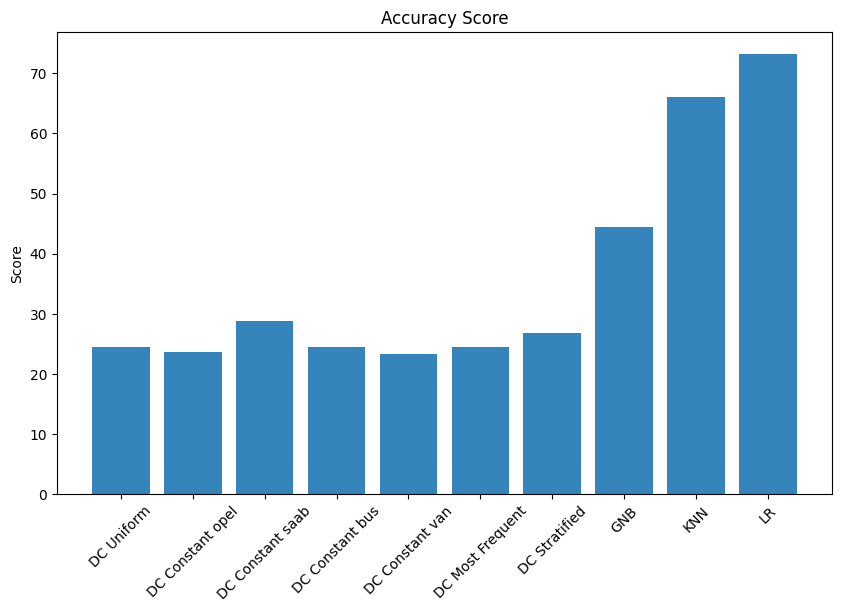

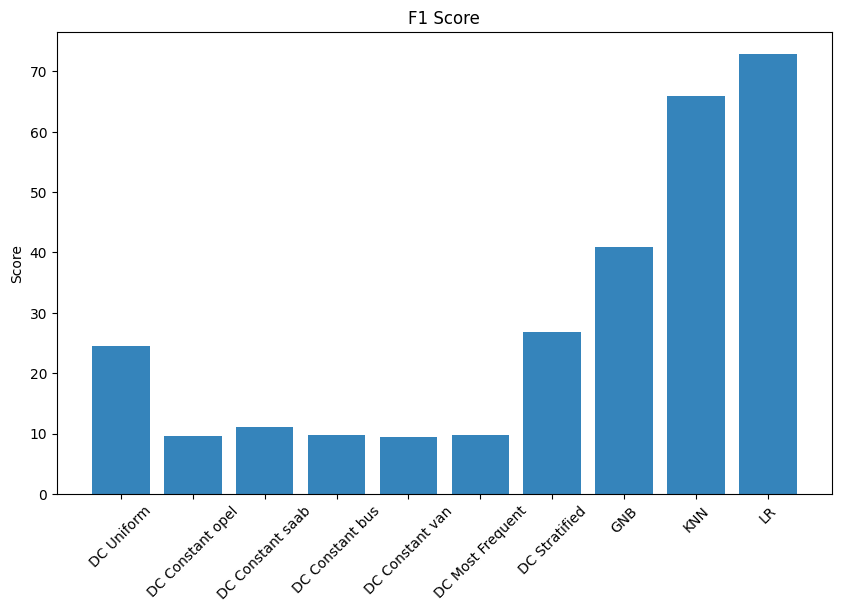

In [27]:
classfication(train_reduced,y_train,test_reduced,y_test)

### Σχολιασμός
Με δοκιμές παρατηρήσαμε ότι οι καλύτερες μετρικές παρατηρούνται με threshold=0, δηλαδή όταν διατηρούνται όλα τα χαρακτηριστικά. 

## Pipelines

In [28]:
from imblearn.pipeline import Pipeline

In [29]:
from sklearn import neighbors

In [30]:
# φέρνουμε τις γνωστές μας κλάσεις για preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler # φέρνουμε τον StandarScaler ως transformer που έχει .transform kai ΄όχι ως scale()
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

# αρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές χωρίς υπερ-παραμέτρους
selector = VarianceThreshold()
scaler = [StandardScaler(),MinMaxScaler()]
ros = [RandomOverSampler(),RandomUnderSampler()]
pca = PCA()

# KNN
knn = neighbors.KNeighborsClassifier(n_jobs=-1) # η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
# GNB
gnb = GaussianNB()
# Logistic Regression
lr = LogisticRegression()

pipes_to_try = [[('selector', selector)]]

for s in scaler:
    pipes_to_try.append(pipes_to_try[0]+[('scaler',s)])

for i in range(1,len(pipes_to_try)):
    pipes_to_try.append(pipes_to_try[i]+[('sampler',ros[0])])
    pipes_to_try.append(pipes_to_try[i]+[('sampler',ros[1])])

for i in range(3,7):
    pipes_to_try.append(pipes_to_try[i]+[('pca',pca)])

classifiers = [('kNN',knn),('GNB',gnb),('Logistic Regression',lr)]
parallels = []

for c in classifiers:
    best = 0
    best_parallel = []
    preds_for_metrics = []
    fit_time = 0
    pred_time = 0        
    for i in pipes_to_try:
        pipe_test = Pipeline(steps = i+[c])
        timer = time.time()
        pipe_test.fit(X_train,y_train)
        demo_fit_time = time.time() - timer
        timer = time.time()
        pred = pipe_test.predict(X_test)
        demo_pred_time = time.time() - timer
        score = f1_score(y_test,pred,average='macro')
        if(score > best):
            best = score
            preds_for_metrics=pred
            best_parallel = i
            fit_time = demo_fit_time
            pred_time = demo_pred_time
        
    parallels.append((c[0],best_parallel+[c]))
    print("best parallel for classifier {} = {}".format(c[0],best_parallel))
    #print(classification_report(y_test, preds_for_metrics))
    print("fit time = {} ||| prediction time = {}".format(fit_time,pred_time))



best parallel for classifier kNN = [('selector', VarianceThreshold()), ('scaler', StandardScaler()), ('sampler', RandomOverSampler()), ('pca', PCA())]
fit time = 0.005148410797119141 ||| prediction time = 0.009448766708374023
best parallel for classifier GNB = [('selector', VarianceThreshold()), ('scaler', StandardScaler()), ('sampler', RandomUnderSampler()), ('pca', PCA())]
fit time = 0.005110979080200195 ||| prediction time = 0.0


C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

best parallel for classifier Logistic Regression = [('selector', VarianceThreshold()), ('scaler', StandardScaler()), ('sampler', RandomUnderSampler()), ('pca', PCA())]
fit time = 0.018292665481567383 ||| prediction time = 0.001003265380859375


In [31]:
pipe_kNN = Pipeline(steps = parallels[0][1],memory="tmp")
pipe_gnb = Pipeline(steps = parallels[1][1],memory="tmp")
pipe_lr = Pipeline(steps = parallels[2][1],memory="tmp")

pipe_kNN.fit(X_train,y_train)
pipe_gnb.fit(X_train,y_train)
pipe_lr.fit(X_train,y_train)

pipe_kNN_score_acc = np.mean(cross_val_score(pipe_kNN,X_train,y_train,scoring = "accuracy",cv=10))
pipe_kNN_score_f1 = np.mean(cross_val_score(pipe_kNN,X_train,y_train,scoring = "f1_macro",cv=10))
pipe_kNN_score = pipe_kNN.score(X_test,y_test)

pipe_gnb_score_acc = np.mean(cross_val_score(pipe_gnb,X_train,y_train,scoring = "accuracy",cv=10))
pipe_gnb_score_f1 = np.mean(cross_val_score(pipe_gnb,X_train,y_train,scoring = "f1_macro",cv=10))
pipe_gnb_score = pipe_gnb.score(X_test,y_test)

pipe_lr_score_acc = np.mean(cross_val_score(pipe_lr,X_train,y_train,scoring = "accuracy",cv=10))
pipe_lr_score_f1 = np.mean(cross_val_score(pipe_lr,X_train,y_train,scoring = "f1_macro",cv=10))
pipe_lr_score = pipe_lr.score(X_test,y_test)

C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Σχολιασμός και συμπεράσματα

In [32]:
pd.DataFrame(data = [[pipe_kNN_score*100,pipe_gnb_score*100,pipe_lr_score*100],[pipe_kNN_score_acc*100,pipe_gnb_score_acc*100,pipe_lr_score_acc*100],[pipe_kNN_score_f1*100,pipe_gnb_score_f1*100,pipe_lr_score_f1*100]], index = ["Score No CV","Accuracy 10 fold CV","f1 10 fold CV"], columns = ["kNN","gnb","lr"])

,kNN,gnb,lr
Score No CV,69.685039,77.165354,79.527559
Accuracy 10 fold CV,71.793785,74.655367,77.709040
f1 10 fold CV,70.810603,74.767238,77.406790


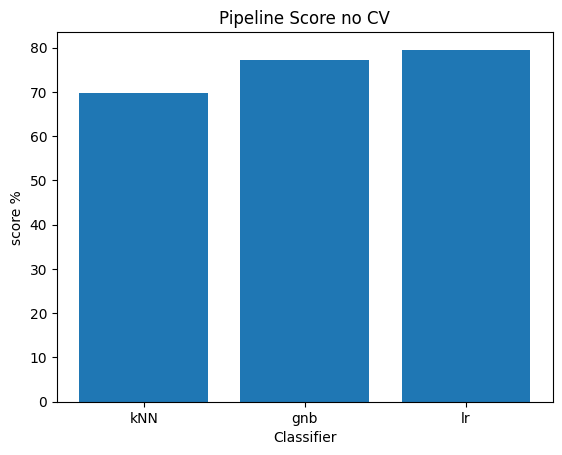

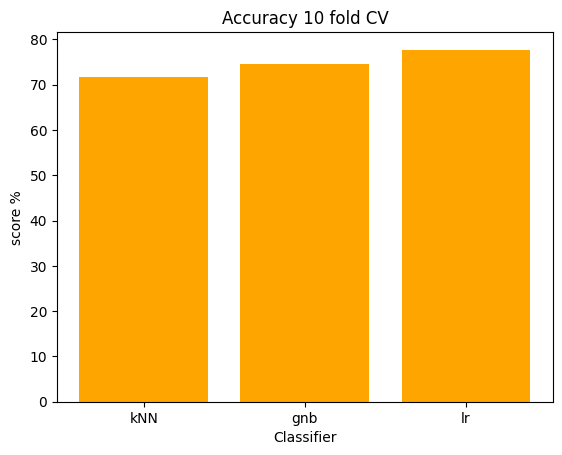

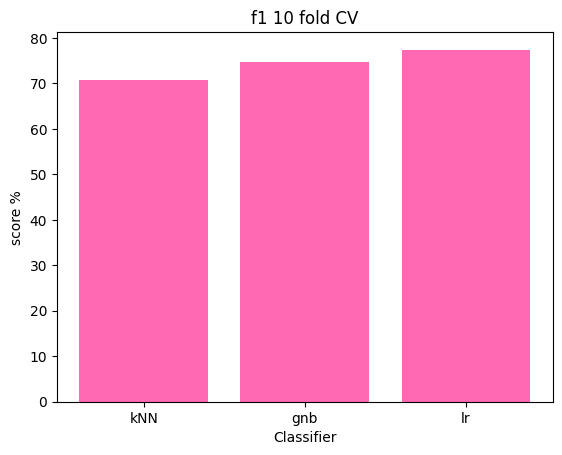

In [33]:
plt.bar(["kNN","gnb","lr"],[pipe_kNN_score*100,pipe_gnb_score*100,pipe_lr_score*100])
plt.title("Pipeline Score no CV")
plt.ylabel("score %")
plt.xlabel("Classifier")
plt.show()
plt.bar(["kNN","gnb","lr"],[pipe_kNN_score_acc*100,pipe_gnb_score_acc*100,pipe_lr_score_acc*100],color="orange")
plt.title("Accuracy 10 fold CV")
plt.ylabel("score %")
plt.xlabel("Classifier")
plt.show()
plt.bar(["kNN","gnb","lr"],[pipe_kNN_score_f1*100,pipe_gnb_score_f1*100,pipe_lr_score_f1*100],color="hotpink")
plt.title("f1 10 fold CV")
plt.ylabel("score %")
plt.xlabel("Classifier")
plt.show()

Στο στάδιο αυτό δοκιμάσαμε διαφορετικούς συνδυασμούς παραμέτρων μέσα στο pipeline έτσι ώστε να καταφέρουμε να μεγιστοποιήσουμε το success rate του ταξινομητή. Τα αποτελέσματα παρατίθενται με την εκτύπωση του βέλτιστου pipeline στο τέλος της εκτέλεσης. Παρατηρούμε ότι υπάρχει βελτίωση της τάξης του 7% (από 73% σε 78% προσεγγιστικά για το 10 fold CV) 

## GridsearchCV

In [34]:
train_variance = np.array(X_train).var(axis=0)
print(train_variance)
print(np.max(train_variance))
print(np.min(train_variance))

[6.85198594e+01 3.85890448e+01 2.46469204e+02 1.14819608e+03
 7.11972243e+01 2.43669164e+01 1.11474566e+03 6.07984386e+01
 6.80676760e+00 2.13487023e+02 1.00764827e+03 3.16678089e+04
 1.07072824e+03 6.14235727e+01 2.39404218e+01 8.04217951e+01
 3.73644511e+01 5.58614751e+01]
31667.808881939396
6.806767599525212


In [35]:
maxvar = np.max(train_variance)
minvar = np.min(train_variance)
print(maxvar)
print(minvar)

31667.808881939396
6.806767599525212


### Σχολιασμός
Σε αυτό όλες τις διακυμάνσεις ώστε να μπορέσουμε να μπορέσουμε να επιλέξουμε να εύρος τιμών για την αναζήτηση πλέγματος.

In [36]:
from sklearn.model_selection import GridSearchCV

vthreshold = list(np.arange(start = 0, stop = 1, step = 0.05))
n_components = [14,15,16,17,18]
k = [10,15,20,25] # η υπερπαράμετρος του ταξινομητή

## kNN

In [37]:
estimator_f1 = GridSearchCV(pipe_kNN, dict(selector__threshold=vthreshold,kNN__n_neighbors=k), cv=10, scoring='f1_macro', n_jobs=-1)
estimator_knn_acc = GridSearchCV(pipe_kNN, dict(selector__threshold=vthreshold,kNN__n_neighbors=k), cv=10, scoring='accuracy', n_jobs=-1)
temp = time.time()
estimator_f1.fit(X_train,y_train)
final_time_knn_f1 = time.time() - temp
temp = time.time()
estimator_knn_acc.fit(X_train,y_train)
final_time_knn_acc = time.time() - temp


In [38]:
knn_pipe_score_f1 = estimator_f1.best_score_
knn_pipe_score_acc = estimator_knn_acc.best_score_

## GNB

In [39]:
estimator_f1 = GridSearchCV(pipe_gnb, dict(selector__threshold=vthreshold, pca__n_components=n_components), cv=10, scoring='f1_macro', n_jobs=-1)
estimator_acc = GridSearchCV(pipe_gnb, dict(selector__threshold=vthreshold, pca__n_components=n_components), cv=10, scoring='accuracy', n_jobs=-1)
temp = time.time()
estimator_f1.fit(X_train,y_train)
final_time_gnb_f1 = time.time() - temp
temp = time.time()
estimator_acc.fit(X_train,y_train)
final_time_gnb_acc = time.time() - temp

In [40]:
gnb_pipe_score_f1 = estimator_f1.best_score_
gnb_pipe_score_acc = estimator_acc.best_score_

## LR

In [41]:
estimator_f1 = GridSearchCV(pipe_lr, dict(selector__threshold=vthreshold), cv=10, scoring='f1_macro', n_jobs=-1)
estimator_lr_acc = GridSearchCV(pipe_lr, dict(selector__threshold=vthreshold), cv=10, scoring='accuracy', n_jobs=-1)
temp = time.time()
estimator_f1.fit(X_train,y_train)
final_time_lr_f1 = time.time() - temp
temp = time.time()
estimator_lr_acc.fit(X_train,y_train)
final_time_lr_acc = time.time() - temp

C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

In [42]:
lr_pipe_score_f1 = estimator_f1.best_score_
lr_pipe_score_acc = estimator_acc.best_score_

### Αποτελέσματα και συμπεράσματα

In [43]:
acc_scores = [knn_pipe_score_acc*100,gnb_pipe_score_acc*100,lr_pipe_score_acc*100]
f1_scores = [knn_pipe_score_f1*100,gnb_pipe_score_f1*100,lr_pipe_score_f1*100]

pd.DataFrame(data = [acc_scores,f1_scores], index = ["Accuracy","f1"], columns = ["kNN","gnb","lr"])

,kNN,gnb,lr
Accuracy,69.943503,74.663842,74.663842
f1,68.244419,74.911604,77.406790


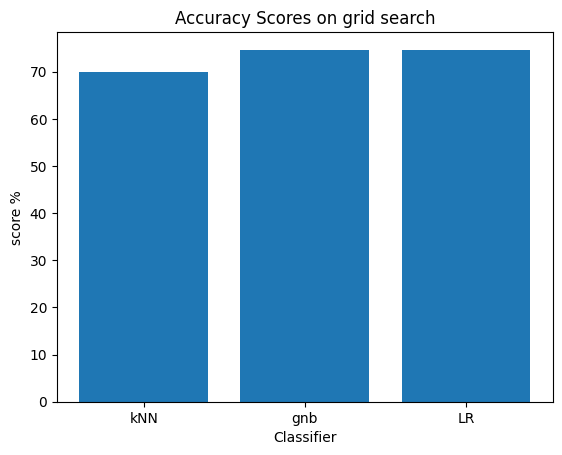

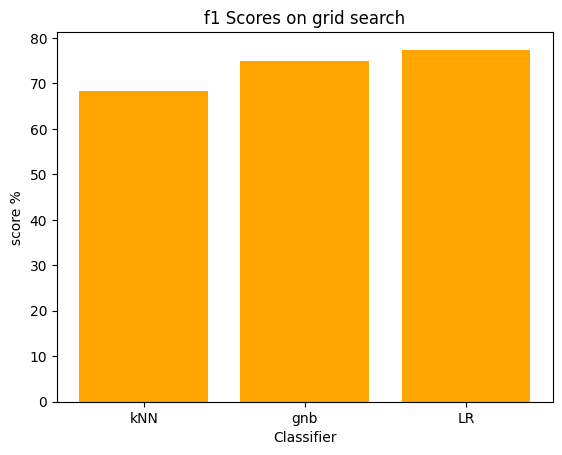

In [44]:
plt.bar(["kNN","gnb","LR"],acc_scores)
plt.title("Accuracy Scores on grid search")
plt.xlabel("Classifier")
plt.ylabel("score %")
plt.show()
plt.bar(["kNN","gnb","LR"],f1_scores,color="orange")
plt.title("f1 Scores on grid search")
plt.xlabel("Classifier")
plt.ylabel("score %")
plt.show()

Παρατηρούμε ότι υπάρχει ξανά μία μέγιστη βελτιστοποίηση της τάξης 5% (από 73% σε 78% προσεγγιστικά) η οποία είναι σχεδόν ταυτόσημη με το score του καλύτερου pipeline που επιλέχθηκε παραπάνω.

## Συνολικά αποτελέσματα/συμπεράσματα

Για τους 3 βασικούς ταξινομητές (kNN, GNB,LR) παραθέτονται οι μετρικές για την αξιολόγηση της βελτιστοποίησης τους.

In [45]:
final_acc_scores = [knn_pipe_score_acc,gnb_pipe_score_acc,lr_pipe_score_acc]
final_f1_scores = [knn_pipe_score_f1,gnb_pipe_score_f1,lr_pipe_score_f1]
final_times_acc = [final_time_knn_acc,final_time_gnb_acc,final_time_lr_acc]
final_times_f1 = [final_time_knn_f1,final_time_gnb_f1,final_time_lr_f1]

In [46]:
names = ["Classifier","Improved Accuracy","OTB Accuracy","Accuracy diff","Improved f1","OTB f1","f1 diff","Improved time","OTB time","time diff"]
final_dict = {
    "Classifier" : ["kNN","GNB","LR"],
    "Improved Accuracy" : final_acc_scores,
    "OTB Accuracy" : scores_acc[1:],
    "Accuracy diff" : [final_acc_scores[i] - scores_acc[i+1] for i in range(3)],
    "Improved f1" : final_f1_scores,
    "OTB f1" : scores_f1[1:],
    "f1 diff" : [final_f1_scores[i] - scores_f1[i+1] for i in range(3)],
    "Improved time acc" : final_times_acc,
    "OTB time acc" : times_acc,
    "time acc diff": [final_times_acc[i] - times_acc[i] for i in range(3)],
    "Improved time f1" : final_times_f1,
    "OTB time f1" : times_f1,
    "time f1 diff": [final_times_f1[i] - times_f1[i] for i in range(3)],    
}

In [47]:
pd.DataFrame(final_dict)

,Classifier,Improved Accuracy,OTB Accuracy,Accuracy diff,Improved f1,OTB f1,f1 diff,Improved time acc,OTB time acc,time acc diff,Improved time f1,OTB time f1,time f1 diff
0,kNN,0.699435,0.643644,0.055791,0.682444,0.635625,0.046820,61.258653,0.274353,60.984300,46.287258,0.214893,46.072365
1,GNB,0.746638,0.457853,0.288785,0.749116,0.424270,0.324846,109.964872,0.207016,109.757857,108.542033,0.199794,108.342239
2,LR,0.746638,0.707797,0.038842,0.774068,0.699300,0.074768,23.631884,0.218567,23.413316,24.146268,0.217565,23.928703


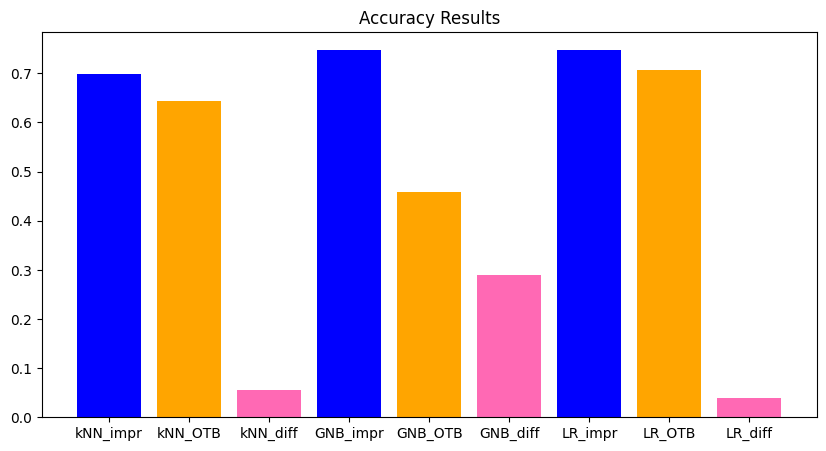

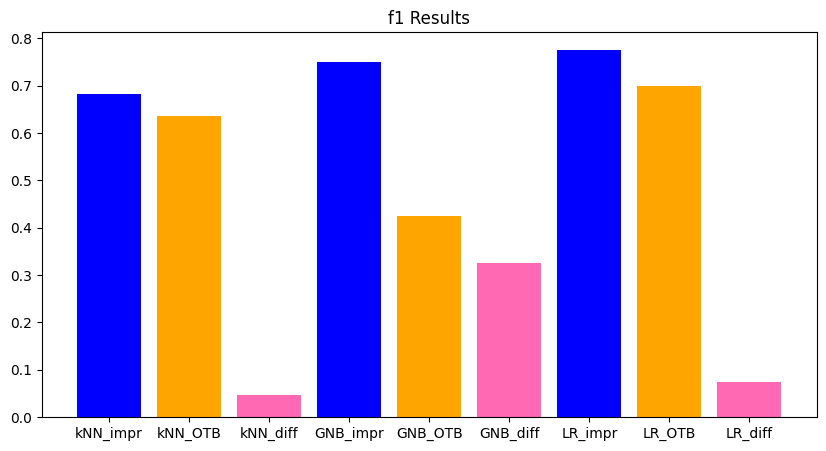

In [48]:
bar_acc = {'kNN_impr':final_acc_scores[0],'kNN_OTB':scores_acc[1],'kNN_diff':final_acc_scores[0]-scores_acc[1], 
            'GNB_impr':final_acc_scores[1],'GNB_OTB':scores_acc[2],'GNB_diff':final_acc_scores[1]-scores_acc[2],
            'LR_impr':final_acc_scores[2],'LR_OTB':scores_acc[3],'LR_diff':final_acc_scores[2]-scores_acc[3]}

bar_f1 = {'kNN_impr':final_f1_scores[0],'kNN_OTB':scores_f1[1],'kNN_diff':final_f1_scores[0]-scores_f1[1], 
            'GNB_impr':final_f1_scores[1],'GNB_OTB':scores_f1[2],'GNB_diff':final_f1_scores[1]-scores_f1[2],
            'LR_impr':final_f1_scores[2],'LR_OTB':scores_f1[3],'LR_diff':final_f1_scores[2]-scores_f1[3]}

colors = ['blue','orange','hotpink']

plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(list(bar_acc.keys()),np.array(list(bar_acc.values())),color = colors)
plt.title("Accuracy Results")
plt.show()
plt.bar(list(bar_f1.keys()),np.array(list(bar_f1.values())),color = colors)
plt.title("f1 Results")
plt.show()

### Confusion Matrix


C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


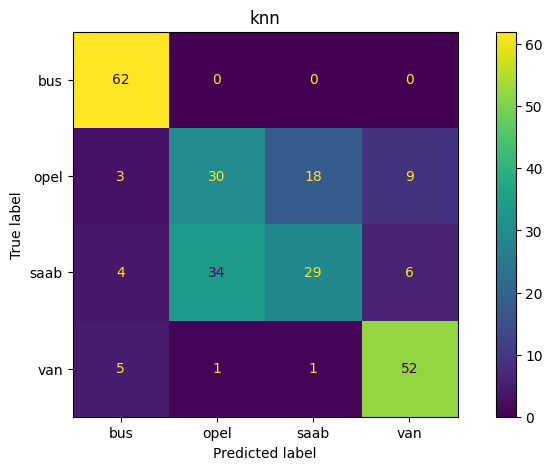

C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


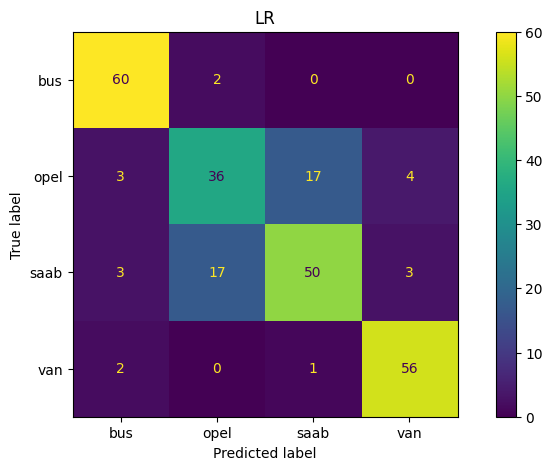

In [50]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt 

#worst classifier: Logistic Regression
y1_pred= estimator_knn_acc.predict(X_test)
M1 = confusion_matrix(y_test, y1_pred)
plot_confusion_matrix(estimator_knn_acc, X_test, y_test)
plt.title("knn")
plt.show()

#best classifier (except from dummy):
y2_pred = estimator_lr_acc.predict(X_test)
M2 = confusion_matrix(y_test, y2_pred)
plot_confusion_matrix(estimator_lr_acc, X_test, y_test)
plt.title("LR")
plt.show()